# Analyse prediction scores & calculate 95%CI

over all bootstrapping iterations 

- metrics assessed:
    - accuracy
    - precision
    - recall
    - f1
    - brier
    - roc-auc
    - precision-recall

- calibration curve

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_imputeScale import pipe_imputation_scaling, pipe_supervisedSelector
from func_preprocess import read_data, subset_wo_missigness, remove_NA, parseVariables, clean_data, impute_scale 
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve, CalibrationDisplay

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
percentBoruta = 100
n_iter = 300

varSet = "fullRegistry"
varFolder = "boruta"
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    

# varSet = "histologie_subgroup"
# varFolder = "manual"
# vars = "onlyHisto"

''' 
Select features
'''

varPath = f"{PATH}/results/20_featureSelection/{varSet}/{varFolder}/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
resultsPath = f"{PATH}/results/30_internalValidation/{varSet}/{vars}"
folderFigures = f"{PATH}/figures/30_internalValidation/{varSet}/{vars}"
figPublicationPath = f'{PATH}/figures/publication/{varSet}'
os.makedirs(figPublicationPath, exist_ok=True)

''' 
Split data
'''
data = read_data(PATH,FILENAME=f"{varSet}")
X = data.drop(target, axis=1)
y = data[target]

print(X.shape)
print(sel_variables)



LOADING DATA
(1814, 39)
['age_erstmanifestation', 'Diagnosedauer', 'scoreadl_neu', 'seelischesbefinden_neu', 'chronicfatigue_normalised', 'autoimmunerkrankungen_rbzu', 'thymektomie_gr']


In [3]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [4]:
dic_performanceScores = {
    "acc":np.array([]),
    "prec":np.array([]),
    "recall":np.array([]),
    "f1-score":np.array([]),
    "brier":np.array([]),
    "roc_auc":np.array([]),
    "pr":np.array([]),
}
for run in range(data.shape[1]):
    predproba = data[run][data[run].notna()]
    pred = predproba.copy()
    pred[predproba < 0.5] = 0
    pred[predproba >= 0.5] = 1
    tru = y.loc[predproba.index]   
    
    ## Accuracy
    dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
    ## Precision
    dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
    ## Recall
    dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
    # F1-score
    dic_performanceScores["f1-score"] = np.append(dic_performanceScores["f1-score"],f1_score(tru, pred))
    ## Brier
    dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
    ## ROC AUC
    dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
    ## PR
    dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

df_scores = pd.DataFrame.from_dict(dic_performanceScores)

""" 
Save
"""
df_scores.to_csv(f"{resultsPath}/summary_scores.csv")



# Calculate CI

In [5]:
""" 
Calculate confidence intervals 
"""
df_ci = pd.DataFrame()
for col in df_scores.columns:
    df_ci[col] = np.array([np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5)])
df_ci.index = ["mean", "lower_CI", "upper_CI"]

#### Save to file
df_ci.to_csv(f"{resultsPath}/bootstrap_CI_95%.csv")

<AxesSubplot:>

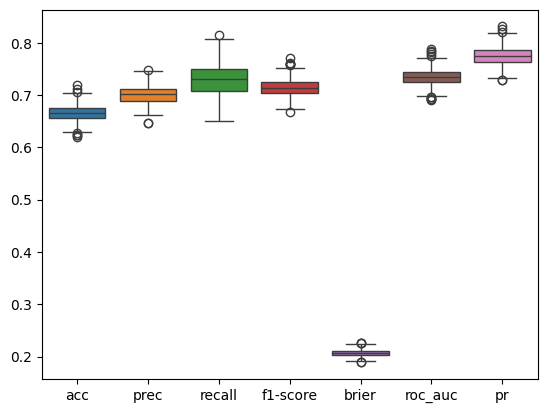

In [6]:
fig, ax = plt.subplots()
df_tmp = df_scores.copy()
sns.boxplot(data=df_tmp)
#ax.set_ylim(0.5, 1)

In [7]:
for i, col in enumerate(df_ci.columns):
    print(col)
    print("%.3f" % df_ci.iloc[0, i], "(95%CI", "%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("%.3f" % df_ci.iloc[0, i],  "(%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])    
    print("\n")

acc
0.666 (95%CI 0.635, 0.699)
0.666 (0.635, 0.699)


prec
0.701 (95%CI 0.667, 0.737)
0.701 (0.667, 0.737)


recall
0.730 (95%CI 0.672, 0.791)
0.730 (0.672, 0.791)


f1-score
0.715 (95%CI 0.681, 0.751)
0.715 (0.681, 0.751)


brier
0.207 (95%CI 0.195, 0.221)
0.207 (0.195, 0.221)


roc_auc
0.735 (95%CI 0.699, 0.770)
0.735 (0.699, 0.770)


pr
0.774 (95%CI 0.739, 0.810)
0.774 (0.739, 0.810)




# Calibration curve

In [8]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [9]:
data = data.mean(axis=1).sort_index()
tru = y.loc[data.index] 

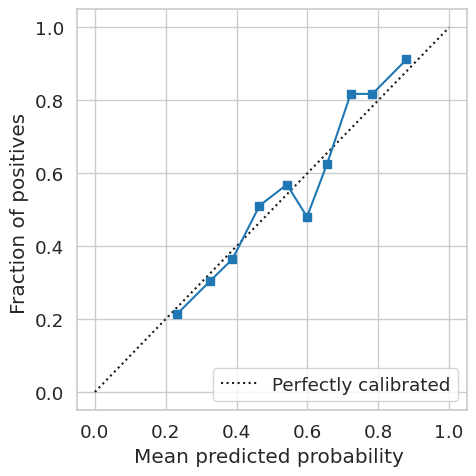

In [10]:
from sklearn.calibration import calibration_curve, CalibrationDisplay


sns.set_theme(style="whitegrid", font_scale=1.2)
fig, ax = plt.subplots(1,1,figsize=(5,5))
prob_true, prob_pred = calibration_curve(tru, data, n_bins=10,strategy="quantile")

CalibrationDisplay(prob_true, prob_pred, data).plot(ax=ax, c="tab:blue")
plt.tight_layout()
fig.savefig(f"{figPublicationPath}/calibrationCurve_development.png", dpi=300)

In [11]:
resultsPath

'/home/WUR/katz001/PROJECTS/myaReg-genderDifferences/results/30_internalValidation/fullRegistry/gender_bootstrapped_iterativeBoruta_100perc'